# NLP Playground
In this notebook we will explore lexicon-based sentiment analysis, some plug-and-play models for text classification, as well as a full fine-tuning pipeline for pre-trained sequence classification models.

In [ ]:
%%capture
%pip install datasets
%pip install -U bitsandbytes

## Imports
Before starting, we need to import the necessary libraries in the colab environment.

In [ ]:
import pandas as pd
import torch
from torch import nn
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    pipeline
)
from datasets import load_dataset

<hr>

## Lexicon-based Approach
Here, we show how to perform sentiment analysis using a lexicon-based approach.

### Load a lexicon
For this example, we are going to use the Distributional Polarity Lexicon (DPL) for Italian texts ([Castellucci et al., 2016](http://sag.art.uniroma2.it/demo-software/distributional-polarity-lexicon/)). You need to import it into Colab first, you can find it [here](https://github.com/istat-methodology/fine-tuning-pipelines/tree/main/colab-tutorials/resources).

In [ ]:
lexicon = pd.read_csv(
    'DPL-IT.txt',
    delimiter='\t',
    header=None,
    names=['word', 'pos', '', 'pos_score', 'neg_score', 'polarity', 'intensity']
)
lexicon['neu_score'] = 1 - lexicon['pos_score'] - lexicon['neg_score']
lexicon = lexicon[['word', 'pos_score', 'neg_score', 'neu_score']]

Extract the list of words contained in the lexicon.

In [ ]:
word_to_sentiment = dict()

for _, row in lexicon.iterrows():
    word = row['word']
    pos_score = row['pos_score']
    neg_score = row['neg_score']
    neu_score = row['neu_score']
    word_to_sentiment[word] = (pos_score, neg_score, neu_score)

lexicon_words = set(str(word) for word in lexicon['word'])

### Sentiment prediction
Now we can predict the sentiment of a text using our lexicon.

In [ ]:
text = 'Oggi è una bellissima giornata'

words = text.lower().split()

pos_score = 0
neg_score = 0

for word in words:
    if word in lexicon_words:
        pos_score += word_to_sentiment[word][0]
        neg_score += word_to_sentiment[word][1]

print(f"Positive score: {round(pos_score, 3)}")
print(f"Negative score: {round(neg_score, 3)}")

<hr>

## Plug-and-play Models

### Fine-tuned BERT
We can import a BERT model fine-tuned on labeled Italian texts (Sentipolc dataset, Basile et al. 2014) from `neuraly/bert-base-italian-cased-sentiment`.

In [ ]:
repo_id = "neuraly/bert-base-italian-cased-sentiment"

tokenizer = AutoTokenizer.from_pretrained(repo_id, clean_up_tokenization_spaces=True)
model = AutoModelForSequenceClassification.from_pretrained(repo_id)

Now we can test the model.

In [ ]:
sentence = "L'Istat si trova al centro di Roma"

input_ids = tokenizer.encode(sentence, add_special_tokens=True)
tensor = torch.tensor(input_ids).long()
tensor = tensor.unsqueeze(0)

out = model(tensor)
logits = out.logits

probs = nn.functional.softmax(logits, dim=1)

neg_prob = probs[0][0].item()
neu_prob = probs[0][1].item()
pos_prob = probs[0][2].item()

print(f"Negative softmax: {round(neg_prob, 3)}")
print(f"Neutral softmax:  {round(neu_prob, 3)}")
print(f"Positive softmax: {round(pos_prob, 3)}")

### Llama 3.2 (1B) Instruct
We can also use a generative LLM like Llama 3.2 (1B) to extract the sentiment from a text.

In [ ]:
llama_pipe = pipeline(
    "text-generation",
    model="unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

In [ ]:
messages = [
    {"role": "system", "content": "Sei un classificatore di sentiment in testi italiani. Rispondi solamente con una parola tra: ['Negativo', 'Neutro', 'Positivo']"},
    {"role": "user", "content": "L'Istat non mi piace"},
]
outputs = llama_pipe(
    messages,
    max_new_tokens=3,
)
print(outputs[0]["generated_text"][-1]['content'])

### Gemma 2 (2B) Instruct
Let's try Google's Gemma model. Unlike Llama models, this model does not support system prompting.

In [ ]:
gemma_pipe = pipeline(
    "text-generation",
    model="unsloth/gemma-2b-it-bnb-4bit",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

In [ ]:
messages = [
    {"role": "user", "content": "Classifica il sentiment del seguente testo utilizzando solamente una parola tra: ['Negativo', 'Neutro', 'Positivo']\n\n\"L'Istat si trova al centro di Roma\""},
]
outputs = gemma_pipe(
    messages,
    max_new_tokens=3,
)
print(outputs[0]["generated_text"][-1]['content'])

<hr>

## Fine-tune your Model
Sometimes, a model for your specific use case might not exist yet, or it might be underperforming. In these cases, granted that you have high quality labeled data, you can fine-tune a pre-trained model. Here you can find code to fine tune Multilingual Robustly Optimized BERT (XLM-RoBERTa), a model pre-trained by FacebookAI (now Meta AI)

In [ ]:
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score

### Configs
Here, you can set some parameters for importing and training. You can find the documentation relative to all these parameters [here](https://huggingface.co/docs/transformers/main_classes/trainer) (or just ask ChatGPT)

In [ ]:
model_id     : str   = 'FacebookAI/xlm-roberta-base'
data_id      : str   = 'istat-ai/sentipolc_dataset'
num_labels   : int   = 3

num_epochs   : int   = 10
learn_rate   : float = 2e-5
scheduler    : str   = 'linear'
train_bs     : int   = 256
eval_bs      : int   = 512
ga_steps     : int   = 2
weight_decay : float = 0.01
warmup_rate  : float = 0.1
fp16         : bool  = True

output_dir   : str   = 'saved_models/xlm-r-base'
log_steps    : int   = 20
eval_strategy: str   = 'steps'
save_strategy: str   = 'steps'
load_best    : bool  = True
log_level    : str   = 'warning'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the Model
Load the model and tokenizer from huggingface. If the model is gated or private, you need to create a huggingface account, generate a token and request access to the gated repository. Luckily, XLM-R is open access.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id, clean_up_tokenization_spaces=True)

### Data Preprocessing
In this tutorial, we will load a public dataset (Sentipolc) from our huggingface profile. If you have custom data, you will have to create your dataset yourself. It is very simple, you can find the documentation [here](https://huggingface.co/docs/datasets/index).

In [ ]:
data = load_dataset(data_id)

The data already has training, validation and test splits. We just need to run some light pre-processing. Basically only tokenization.

In [ ]:
def tokenize(example):
    return tokenizer(example['text'], padding=True, truncation=True, max_length=tokenizer.model_max_length)

tokenized_data = data.map(tokenize, batched=True)

### Training
First, you need to manually define a funcion to compute the metrics that you want to monitor at each logging step during training.

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': accuracy, 'f1_macro': f1}

Then, you need to define the `TrainingArguments` and `Trainer` classes. We will use the configs defined above.

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_epochs,
    learning_rate=learn_rate,
    lr_scheduler_type=scheduler,
    per_device_train_batch_size=train_bs,
    per_device_eval_batch_size=eval_bs,
    gradient_accumulation_steps=ga_steps,
    warmup_ratio=warmup_rate,
    weight_decay=weight_decay,
    logging_dir='./logs',
    logging_steps=log_steps,
    eval_strategy=eval_strategy,
    save_strategy=save_strategy,
    fp16=fp16,
    report_to=[],
    load_best_model_at_end=load_best,
    log_level=log_level,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['eval'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Finally, you can train your model.

In [ ]:
trainer.train()

### Evaluation
Now, you can evaluate the model on the test set.

In [ ]:
eval_results = trainer.evaluate(tokenized_data['test'])
eval_results

### Inference
Finally, you can use your fine-tuned model to run inference.

In [ ]:
text = "L'Istat è un bellissimo posto"

input_ids = tokenizer.encode(text, add_special_tokens=True)
tensor = torch.tensor(input_ids).long()
tensor = tensor.unsqueeze(0)

out = model(tensor.to(device))
logits = out.logits

probs = nn.functional.softmax(logits, dim=1)

neg_prob = probs[0][0].item()
neu_prob = probs[0][2].item()
pos_prob = probs[0][1].item()

print(f"Negative softmax: {round(neg_prob, 3)}")
print(f"Neutral softmax:  {round(neu_prob, 3)}")
print(f"Positive softmax: {round(pos_prob, 3)}")

### Export to Huggingface
If you want, you can very easily export the model  to your huggingface.

In [ ]:
repo_name   : str  = 'your_username/xlm-r-base-sentiment-ita'
private_repo: bool = True

trainer.push_to_hub(repo_name, private=private_repo)

And re-import it whenever you want.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(repo_name)
tokenizer = AutoTokenizer.from_pretrained(repo_name)

<hr>

Follow us on [GitHub](https://github.com/istat-methodology) and [Hugging Face](https://huggingface.co/istat-ai) for upcoming open-source code and research! :)

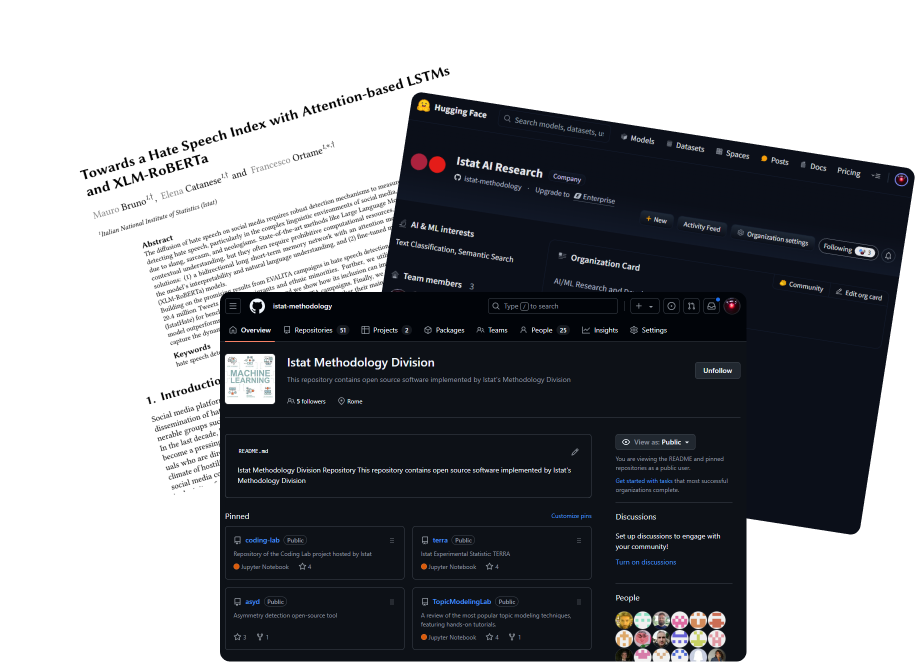